In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_models_epochs(file_dict):
    row = []
    for alias, file_path in file_dict.items():
        folder = str(file_path).split('/')[:-1]
        ckp1 = '/'.join(folder)+'/'+folder[-1]+'_best.pth'
        if alias == "$S_2$":
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_119.pth'
        else:
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_curr.pth'
        epoch1 = util.get_checkpoint_epoch(ckp1)
        epoch2 = util.get_checkpoint_epoch(ckp2)
        row.append((alias, epoch1, epoch2))
    return pd.DataFrame(row, columns =['Name', 'best', 'curr'])


def get_confidence(scores, targets):
    targets = targets.astype(int)
    kn = targets >= 0
    ku = targets == -1
    uu = targets == -2
    C = scores.shape[1]
    weights = np.array([sum(kn), sum(ku), sum(uu)])/C
    ckk = np.mean(scores[kn,targets[kn]])
    cku = np.mean(1 - np.amax(scores[ku], axis=1) + 1/C)
    
    if sum(uu) != 0:
        cuu = np.mean(1 - np.amax(scores[uu], axis=1) + 1/C)
        c_mean = np.average(np.array([ckk, cku, cuu]), weights=weights)
    else:
        c_mean = np.average(np.array([ckk, cku]), weights=weights[:-1])
        cuu = -1
    return ckk, cku, cuu, c_mean

In [7]:
results = Path('../../results')
a = np.load(results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz')
#['gt', 'logits', 'features', 'scores']
a['logits'][:,:-1].shape

(46481, 115)

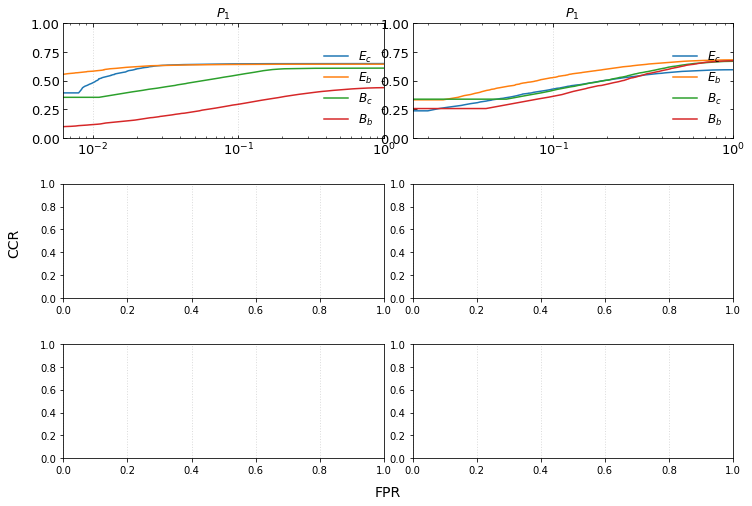

In [15]:
import sys
sys.path.append("../")
import src.util as util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# General Experiments
results = Path('../../results')
outputs = Path('../outputs/')

p1_paths = {
    '$S_1$':    results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_1$':    results/'e1n_w1_l1_e0_sgd_d40_g0.3/e1n_w1_l1_e0_sgd_d40_g0.3_curr_val_arr.npz',
    '$B_c$':    outputs/'g1n_l1_e0_adam/g1n_l1_e0_adam_curr_val_arr.npz',
    '$B_b$':    outputs/'g1n_l1_e0_adam/g1n_l1_e0_adam_best_val_arr.npz',
    # '$O_1$':    results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    }

p2_paths = {    
    # '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    '$E_c$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
    '$E_b$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
    # '$O_2$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
    '$B_c$':    outputs/'g2n_l1_e0_adam/g2n_l1_e0_adam_curr_val_arr.npz',
    '$B_b$':    outputs/'g2n_l1_e0_adam/g2n_l1_e0_adam_best_val_arr.npz'
    }

p3_paths = {
    '$S_3$':    results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$':    results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$O_3$':    results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    }

# p1_best_val = util.read_array_list(util.get_best_arrays(p1_paths))
p1_val = util.read_array_list(p1_paths)
p2_val = util.read_array_list(p2_paths)
# p1_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p1_paths)))
# p2_best_val = util.read_array_list(util.get_best_arrays(p2_paths))
# p2_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths)))
# p3_best_val = util.read_array_list(util.get_best_arrays(p3_paths))
# p3_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_paths)))

points = 200
font = 14
linewidth=2
fig = plt.figure(figsize=(12,8))  
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
axs = axs.flat
util.plot_oscr(p1_val, split='val', scale='semilog', use_norms=False, title='$P_1$', ax_label_font=13, ax=axs[0],
              legend_pos="lower right", points=points)
util.plot_oscr(p2_val, split='val', scale='semilog', use_norms=False, title='$P_1$', ax_label_font=13, ax=axs[1],
              legend_pos="lower right", points=points)

# util.plot_oscr(p2_best_val, split='val', scale='log', use_norms=False, title='$P_2$', ax_label_font=13, ax=axs[2],
#               legend_pos="lower right", points=points)
# util.plot_oscr(p2_best_test, split='test', scale='log', use_norms=False, title='$P_2$', ax_label_font=13, ax=axs[3],
#               legend_pos="lower right", points=points)


# util.plot_oscr(p1_best_test, split='test', scale='log', use_norms=False, base_line=True,
#                title='$P_1$ test', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)


for ax in axs:
    # ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.06, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/base_noadv_allp.pdf', dpi=100, bbox_inches='tight')
plt.show()
# get_models_epochs(p2_files1)